In [1]:
import argparse
import tensorflow as tf
import os
import numpy as np
from tensorflow.contrib import predictor
from models import input_fn
from models import CRNN as Model
from datahandler import DataHandler
from config import Config
import pickle
import traceback

def serving_input_receiver_fn():
    '''
    Serving input receiver function for tf.Estimator.export_savedmodel
    :return: a TensorServingInputReceiver fitting the input data specified in cf.hparams
    '''
    features = tf.placeholder(shape=[None, cf.hparams.n_epoch_samples, cf.hparams.n_channels], dtype=tf.float32)
    receiver_tensors = features
    return tf.estimator.export.TensorServingInputReceiver(features, receiver_tensors)

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

In [2]:
cf = Config('r-c-shhs',
            'cluster',
            'revised-shallow',
            None).get_configs(cross_validate=6,
                                 matched=True)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=6)

Restoring partitions for: /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/cv6/


In [2]:
cf = Config('c-simulated',
            'cluster',
            'revised-shallow',
            None).get_configs(cross_validate=None)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=None)

Restoring partitions


In [ ]:
cf = Config('n2rem',
            'local',
            'revised-shallow-n2rem',
            None).get_configs(cross_validate=None)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=None)

In [2]:
cf = Config('c-shhs',
            'cluster',
            'revised2-shallow',
            None).get_configs(cross_validate=5,
                                     matched=True)

DataHandler.setup_partitions(cf,
                             model_memory=True,
                             cross_validate=5)

Something is wrong with shhs1-202852
Something is wrong with shhs1-201652
Restoring partitions for: /scratch/users/rmth/tf_logs/c-shhs_cluster_revised2-shallow_cv/cv5/


In [3]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps=cf.eparams.save_checkpoint_steps,
                                    save_summary_steps=cf.eparams.save_summary_steps)

model = Model('CRNN', cf.eparams)

classifier = tf.estimator.Estimator(
    model_fn=lambda features, labels, mode: model(features, labels, mode, cf.hparams),
    model_dir=cf.eparams.ckptdir,
    config=run_config)

classifier.export_savedmodel(export_dir_base=cf.eparams.ckptdir,
                             serving_input_receiver_fn=serving_input_receiver_fn)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5fd9dd93d0>, '_evaluation_master': '', '_save_checkpoints_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/cv6/', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
X: (?, 2, 60, 1, 625)
conv_block_1/conv1: (?, 32, 60, 1, 618)
conv_block_1/conv2: (?, 32, 60, 1, 611)
conv_block_1/pool: (?, 32, 60, 1, 303)
conv_block_2/conv1: (?, 64, 60, 1, 296)
conv_block_2/conv2: (?, 64, 60, 1, 289)
conv_block_2/pool: (?, 64, 60, 1, 142)
conv_block_3/conv1: (?, 128, 60,

'/scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/cv6/1528617465'

In [3]:
exports = [int(e) for e in os.listdir(cf.eparams.ckptdir) if e.isdigit()]
export_dir = os.path.abspath(cf.eparams.ckptdir + str(exports[np.argmax(exports)]))
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/cv6/1528617465/variables/variables


In [7]:
include_matched = False
do_td = True
trainIDs = DataHandler.partitions['train']
valIDs = DataHandler.partitions['val']
testIDs = DataHandler.partitions['test']
if include_matched:
    matchedIDs = DataHandler.partitions['matched']
train_probs = {}
train_group = {}
train_feat = {}
#train_sens = {}
val_probs = {}
val_group = {}
val_feat = {}
#val_sens = {}
test_probs = {}
test_group = {}
test_feat = {}
test_sens = {}
if include_matched:
    matched_probs = {}
    matched_group = {}
    matched_feat = {}
    matched_sens = {}
    total_records = len(trainIDs + valIDs + testIDs+ matchedIDs)
else:
    total_records = len(trainIDs + valIDs + testIDs)

In [8]:
ssc = True
def run_inference(id, partition, td = False):
    features, labels = input_fn(partition, cf.eparams, id)
    prob = []
    feat = []
    signal = []
    exp_sens = []
    con_sens = []
    while True:
        try:
            # this will break when input_fn can't make a full 16 times 5 min input
            # todo: use smaller batch, or zero pad for missing in batch
            x, y = sess.run([features, labels])
            predictions = predict_fn({"input": x})
            prob.append(np.transpose(predictions['probabilities'][:, 1]))
            feat.append(np.transpose(predictions['features']))
            if td:
                #print(x.shape)
                signal.append(x)
                exp_sens.append(predictions['experimental_sensitivity'])
                con_sens.append(predictions['control_sensitivity'])
        except:
            #print('{}: done processing {}'.format(partition, id))
            break
            
    features = np.reshape(np.transpose(np.asarray(feat), [0, 2, 1]), [len(feat)*4, -1])
    if not td:
        return np.argmax(y[0,:]), np.reshape(np.asarray(prob), [-1]), features
    else:
        #print(np.asarray(signal).shape)
        #signal = np.reshape( np.transpose(np.asarray(signal), [2, 4, 5, 0, 1, 3]), [2, 625, -1])
        arr = np.transpose(np.asarray(con_sens), [2, 4, 5, 0, 1, 3])
        n_channels = arr.shape[0]
        n_samples = arr.shape[2]
        td_con = np.reshape( arr, [n_channels, n_samples, -1])
        td_exp = np.reshape( np.transpose(np.asarray(exp_sens), [2, 4, 5, 0, 1, 3]), [n_channels, n_samples, -1])
        taylor_decomp = np.stack([td_con, td_exp], axis=3)
        return np.argmax(y[0,:]), np.reshape(np.asarray(prob), [-1]), features, taylor_decomp

In [9]:
with tf.Session() as sess:
    '''
    for step, id in enumerate(trainIDs):
        try:
            train_group[id], train_probs[id], train_feat[id] = run_inference(id, 'train_id')
            print('{}: done processing {} ({} of {})'.format('train_id', id, step+1, len(trainIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('train_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs), total_records))
    for step,id in enumerate(valIDs):
        try:
            val_group[id], val_probs[id], val_feat[id] = run_inference(id, 'val_id')
            print('{}: done processing {} ({} of {})'.format('val_id', id, step+1, len(valIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('val_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs+valIDs), total_records))
    '''        
    for step,id in enumerate(testIDs):
        try:
            test_group[id], test_probs[id], test_feat[id], test_sens[id] = run_inference(id, 'test_id', td=do_td)
            print('{}: done processing {} ({} of {})'.format('test_id', id, step+1, len(testIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('test_id', id))
    print('Done processing {} of a total of {}'.format(len(trainIDs+valIDs+testIDs), total_records))
    '''
    for step,id in enumerate(matchedIDs):
        try:
            matched_group[id], matched_probs[id], matched_feat[id], matched_feat[id] = run_inference(id, 'matched_id', td=do_td)
            print('{}: done processing {} ({} of {})'.format('matched_id', id, step+1, len(matchedIDs)))
        except Exception as e:
            print(e)
            print(traceback.format_exc())
            print('{}: error processing {}'.format('matched_id', id))
    '''


test_id: done processing shhs1-200375 (1 of 55)
test_id: done processing shhs1-203061 (2 of 55)
test_id: done processing shhs1-204256 (3 of 55)
test_id: done processing shhs1-200968 (4 of 55)
test_id: done processing shhs1-204188 (5 of 55)
test_id: done processing shhs1-201757 (6 of 55)
test_id: done processing shhs1-202680 (7 of 55)
test_id: done processing shhs1-201654 (8 of 55)
test_id: done processing shhs1-201674 (9 of 55)
test_id: done processing shhs1-200993 (10 of 55)
test_id: done processing shhs1-200080 (11 of 55)
test_id: done processing shhs1-202028 (12 of 55)
test_id: done processing shhs1-200798 (13 of 55)
axes don't match array
Traceback (most recent call last):
  File "<ipython-input-9-ba5d3992d0b1>", line 24, in <module>
    test_group[id], test_probs[id], test_feat[id], test_sens[id] = run_inference(id, 'test_id', td=do_td)
  File "<ipython-input-8-3b6c69ef906e>", line 25, in run_inference
    features = np.reshape(np.transpose(np.asarray(feat), [0, 2, 1]), [len(feat)

axes don't match array
Traceback (most recent call last):
  File "<ipython-input-9-ba5d3992d0b1>", line 24, in <module>
    test_group[id], test_probs[id], test_feat[id], test_sens[id] = run_inference(id, 'test_id', td=do_td)
  File "<ipython-input-8-3b6c69ef906e>", line 25, in run_inference
    features = np.reshape(np.transpose(np.asarray(feat), [0, 2, 1]), [len(feat)*4, -1])
  File "/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 550, in transpose
    return _wrapfunc(a, 'transpose', axes)
  File "/share/software/user/open/py-scipystack/1.0_py27/lib/python2.7/site-packages/numpy/core/fromnumeric.py", line 57, in _wrapfunc
    return getattr(obj, method)(*args, **kwds)
ValueError: axes don't match array

test_id: error processing shhs1-201969
Done processing 495 of a total of 568


In [10]:
'''
print('Exporting probabilities to: {}'.format(cf.eparams.ckptdir + 'eval/probabilities.pkl'))
with open(cf.eparams.ckptdir + 'eval/probabilities.pkl', 'wb') as f:
    pickle.dump([train_group, train_probs, val_group, val_probs, test_group, test_probs, matched_probs, matched_group], f)

print('Exporting features to: {}'.format(cf.eparams.ckptdir + 'eval/features.pkl'))
with open(cf.eparams.ckptdir + 'eval/features.pkl', 'wb') as f:
    pickle.dump(
        [train_group, train_feat, val_group, val_feat, test_group, test_feat, matched_feat, matched_group],
        f)
    
print('Exporting taylor decompositions to: {}'.format(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl'))
with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'wb') as f:
    pickle.dump(
        [test_sens, test_group, matched_sens, matched_group], f)
'''
    
print('Exporting taylor decompositions to: {}'.format(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl'))
with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'wb') as f:
        pickle.dump([test_sens, test_group], f)
        
print('Done processing all.')

Exporting taylor decompositions to: /scratch/users/rmth/tf_logs/r-c-shhs_cluster_revised-shallow_cv/cv6/eval/taylor_decompositions.pkl
Done processing all.


In [3]:
from scipy.ndimage.filters import gaussian_filter as gf
from scipy.signal import find_peaks_cwt
from sklearn.manifold import TSNE
from scipy.signal import welch
import h5py
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.decomposition import PCA

In [16]:
simulated = False
revised = False
n2rem = True

if simulated or revised or n2rem:
    with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'rb') as f:
        test_sens, test_group = pickle.load(f)
else:
    with open(cf.eparams.ckptdir + 'eval/taylor_decompositions.pkl', 'rb') as f:
        test_sens, test_group, matched_sens, matched_group = pickle.load(f)
        
sns.set()
if simulated:
    data_folder = '/scratch/users/rmth/simulated_data/'
elif n2rem:
    data_folder = '/home/rasmus/Desktop/SSC/processed_data/'
elif revised:
    data_folder = '/scratch/users/rmth/processed_shhs_data_revised/'
else:
    data_folder = '/scratch/users/rmth/processed_shhs_data/'
n_samples_subepoch = 625

In [17]:
def evidence_difference(td, group):
    pos = copy.deepcopy(td)
    pos[pos < 0] = 0
    #neg = copy.deepcopy(td)
    #neg[neg > 0] = 0
    #neg_evidence = np.abs(np.sum(neg))
    pos_evidence = np.trapz(pos)
    #evidence_diff = pos_evidenc - neg_evidence
    #evidence_diff = np.trapz(td)
    evidence_diff = pos_evidence# np.trapz(td)
    if group:
        return evidence_diff
    else:
        return -evidence_diff
    #return evidence_diff

(2, 98, 37500)


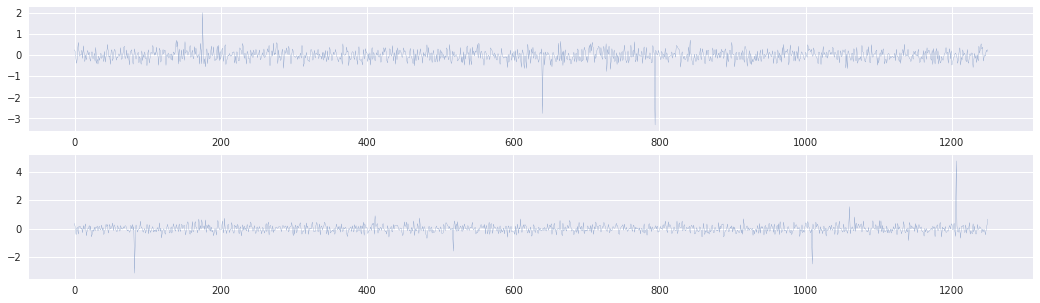

In [24]:
for pred, id in enumerate(test_sens):
    #print(int((pred+1)/len(test_sens)*100.0))
    if pred != 0:
        continue
    path = data_folder + id + '.hpf5'
    with h5py.File(path, "r") as f:
        dset = np.array(f["x"])
        data = np.squeeze(dset[:, :, :])
        print(data.shape)
        n_channels = data.shape[0]
        n_epochs = data.shape[1]
        n_samples = data.shape[2]
        data = np.transpose(data, [0, 1, 2])
        data = np.reshape(data, [n_channels, n_epochs, -1, n_samples])
        data = np.reshape(data, [n_channels, -1, n_samples])
        data = np.transpose(data, [0, 2, 1])
        data = data[:,:,:test_sens[id].shape[2]]
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (5,5))
    ax[0].plot(data[0,7,:])
    #ax[0].set_xlim([0,1000])
    ax[1].plot(data[1,7,:])
    #ax[1].set_xlim([0,1000])
    
    
plt.show()

In [70]:

if simulated:
    grp_names = ['Sine', 'Saw-tooth']
elif n2rem:
    grp_names = ['REM', 'N2']
else:
    grp_names = ['Non-stroke', 'Stroke']

if n2rem:
    chn_names = ['C3', 'C4', 'Fz', 'ROC', 'LOC', 'Chin']
else:
    chn_names = ['C3', 'C4']

if n2rem:
    fs = 128
else:
    fs = 125.0
do_plotting = False


pct_val = 95
std_multi = 5
smoothening = 10
std_peaks = []
std_evidence = []
std_spec = []
std_id = []
for pred, id in enumerate(test_sens):
    #if pred != 0:
    #    continue
    print(pred)
    #print(int((pred+1)/len(test_sens)*100.0))
    #if pred == 0 or pred == 50:
    #    print('lol')
    #else: 
    #    continue
    path = data_folder + id + '.hpf5'
    with h5py.File(path, "r") as f:
                    dset = np.array(f["x"])
                    data = np.squeeze(dset[:, :, :])
                    data = np.transpose(data, [0, 1, 2])
                    data = np.reshape(data, [2, data.shape[1], -1, n_samples_subepoch])
                    data = np.reshape(data, [2, -1, 625])
                    data = np.transpose(data, [0, 2, 1])
                    data = data[:,:,:test_sens[id].shape[2]]
    sens = test_sens[id]
    grp = test_group[id]
    
    #print(data.shape) # (2, 625, 5760)
    #print(sens.shape) # (2, 625, 5760, 2)
    print('Group: {}'.format(grp_names[grp]))
    if do_plotting:
        idx = 501
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
        yl = 0.2
        yld = 7
        t = np.arange(0, int(data.shape[1]//fs), 1/fs)
        for channel in range(2):
            ax[0, channel].plot(t,data[channel, :, idx],'k')
            ax[0, channel].set_ylim([-yld, yld])
            ax[0, channel].set_title(chn_names[channel])
        for group in range(2):
            for channel in range(2):
                x = gf(sens[channel, :, idx, group], smoothening)
                ax[group+1, channel].plot(t,x)
                ax[group+1, channel].set_ylim([-yl, yl])
                ax[group+1, channel].set_title(r'$\theta(t)$ ({}, {})'.format(chn_names[channel], grp_names[group]))
        plt.show()
    
    n_chans = sens.shape[0]
    n_subepochs = sens.shape[2]
    n_classes = sens.shape[3]
    evi_diff = np.empty([n_chans, n_subepochs, n_classes])
    for chan in range(n_chans):
        for subepoch in range(n_subepochs):
            for group in range(n_classes):
                #x = sens[chan, :, subepoch, group]
                x = gf(sens[chan, :, subepoch, group], smoothening)
                evi_diff[chan, subepoch, group] = evidence_difference(x, group)
    
    idx = np.unravel_index(np.argmax(np.abs(evi_diff)), evi_diff.shape)
    print(idx)
    idx = idx[1]
    if do_plotting:
        fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(13,20))
        print('Group: {}'.format(grp_names[grp]))
        for channel in range(2):
            ax[0, channel].plot(t,data[channel, :, idx],'k')
            ax[0, channel].set_xlabel('Time [s]', fontsize=15)
            ax[0, channel].set_ylabel('Amplitude [V]', fontsize=15)
            ax[0, channel].autoscale(enable=True, axis='x', tight=True)
            #x = data[channel, :, idx]
            #y = sens[channel, :, idx, 1]
            #t = np.arange(0, 5, 1/fs)
            #ax[0, channel].scatter(t,x, 5, y,cmap='seismic', vmin=-0.05, vmax=0.05)
            ax[0, channel].set_ylim([-yld, yld])
            ax[0, channel].set_title('EEG: {}'.format(chn_names[channel]), fontsize=17)
        for group in range(2):
            for channel in range(2):
                x = gf(sens[channel, :, idx, group], smoothening)
                ax[group+1, channel].plot(t,x)
                ax[group+1, channel].set_xlabel('Time [s]', fontsize=15)
                ax[group+1, channel].set_ylabel(r'$\theta(t)$', fontsize=15)
                ax[group+1, channel].set_ylim([-yl, yl])
                ax[group+1, channel].autoscale(enable=True, axis='x', tight=True)
                ax[group+1, channel].set_title('Taylor Decomposition: {}, {}'.format(chn_names[channel], grp_names[group]), fontsize=17)

        #print(evi_diff.shape) # (2, 5760, 2)

        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
        xl = 2
        for chn in range(2):
            for grp in range(2):
                ax[chn,grp].hist(evi_diff[chn,:,grp],bins=100)
                ax[chn,grp].set_title([chn_names[chn], grp_names[grp]])
                ax[chn,grp].set_xlim([-xl, xl])
                ax[chn,grp].set_xticks([-.5*xl, 0, .5*xl])
                ax[chn,grp].set_xticklabels(['More no', 0, 'More yes'])
                ax[chn,grp].set_ylim([0, 2500])

        plt.show()
        
    pct0 = np.std(np.abs(evi_diff[:,:,0]))*std_multi
    pct1 = np.std(np.abs(evi_diff[:,:,1]))*std_multi
    #print(pct0)
    #print(pct1)
    
    #pct0 = np.percentile(np.abs(evi_diff[:,:,0]), pct_val)
    #pct1 = np.percentile(np.abs(evi_diff[:,:,1]), pct_val)
    #print(pct0)
    
    above_pct0 = np.abs(evi_diff[:,:,0]) > pct0
    above_pct1 = np.abs(evi_diff[:,:,1]) > pct1
    #print(evi_diff.shape) # (2, 5760, 2), (channel, subepoch, class)
    #print(data.shape) # (2,625,5760), (channel, sample, subepoch)
    #print(test.shape) # (2,5760,2) (channel, subepoch, class)
    for subepoch in range(n_subepochs):
        cond0 = (sum(above_pct0[:,subepoch])) != 0
        cond1 = (sum(above_pct1[:,subepoch])) != 0
        if cond0 or cond1:
            if n2rem:
                peak = data[:,:,subepoch]
            else:
                peak = data[:,:,subepoch-1:subepoch+2]
                if peak.shape != (2,625,3):
                    print('Window at end of segment. Ignoring.')
                    continue
                peak = np.transpose(peak,[0,2,1])
                peak = np.reshape(peak, [2, -1])
            evidence = evi_diff[:,subepoch,:]
            f,Pxx = welch(peak, fs = fs, nperseg = 3*fs, nfft = 512)
            Pxx = 10*np.log10(Pxx)
            Pxx = Pxx / np.sum(Pxx)
          
            std_evidence.append(evidence)
            std_peaks.append(peak)
            std_spec.append(Pxx
            std_id.append(id)
            

0
Group: Saw-tooth
(0, 2560, 1)
1
Group: Saw-tooth
(0, 3025, 1)
2
Group: Saw-tooth
(0, 744, 1)
3
Group: Sine
(1, 2761, 0)
4
Group: Sine
(1, 5177, 1)


In [72]:
peaks = np.asarray(std_peaks)
ids = np.asarray(std_id)
specs = np.asarray(std_spec)
evidence = np.asarray(std_evidence)
specs = np.reshape(specs, [-1, 2*257])
pca = PCA(n_components=20)
red = pca.fit_transform(specs)

<IPython.core.display.Javascript object>


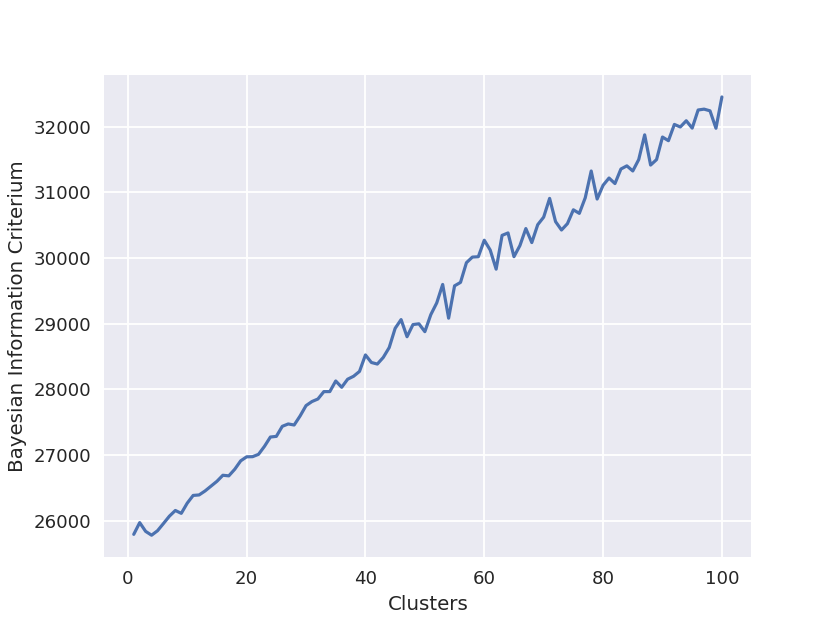

In [200]:
K = 100
kf = KFold(n_splits=3)
llh = []
for k in range(K):
    llh_splits = []
    for train, test in kf.split(red):
        gm = GaussianMixture(n_components=k+1, n_init = 1, covariance_type = 'spherical', reg_covar = 1e-3)
        gm.fit(red[train,:])
        llh_splits.append(gm.bic(red[test,:]))
    llh.append(np.mean(llh_splits))
    
fig,ax = plt.subplots(nrows=1,ncols=1)
ax.plot(np.arange(1,K+1), llh)
ax.set_xlabel('Clusters')
ax.set_ylabel('Bayesian Information Criterium')
plt.show()

In [78]:
#gm = GaussianMixture(n_components=np.argmin(llh)+1, n_init = 3)
#gm = GaussianMixture(n_components=50, n_init = 3)
#gm.fit(red)
#grp = gm.predict(red)
tsne = TSNE(n_components=2, n_iter = 20000, perplexity=30)
red = tsne.fit_transform(specs)
#pca = PCA(n_components=20)
#red = pca.fit_transform(specs)



In [ ]:
gm = GaussianMixture(n_components=8, n_init = 3)
gm.fit(red)
grp = gm.predict(red)


In [91]:
print(evidence.shape)
v = np.max(evidence) 
print(v)

total_evidence = np.mean((evidence), axis = 1)
total_evidence = np.mean(total_evidence, axis = 1)

K = np.max(grp)
grp_evidence = []
for k in range(K+1):
    grp_evidence.append(np.mean(total_evidence[grp == k]))
    
'''
K = np.max(grp)
grp_evidence = []
for k in range(K+1):
    grp_evidence.append(np.mean(total_evidence[grp == k]))

n_clusters = 8
n_cl = n_clusters//2

sorted_group = [x for _,x in sorted(zip(grp_evidence,np.arange(0,K)))]
grp_indices = sorted_group[:n_cl] + sorted_group[-n_cl:]

cluster_names = ['Non-stroke', 'Non-stroke','Non-stroke','Non-stroke', 'Stroke','Stroke','Stroke', 'Stroke']

n_cluster_examples = 7
'''

n_clusters = 2
cluster_names = [grp_names[0], grp_names[1]]
n_cl = n_clusters//2
n_cluster_examples = 5

restart = True
step = 0
while restart:
    step += 1
    if step == 4: break
    sorted_group = [x for _,x in sorted(zip(grp_evidence,np.arange(0,K)))]
    grp_indices = sorted_group[:n_cl] + sorted_group[-n_cl:]
    restart = False
    for k in range(len(grp_indices)):
        cluster_peaks = peaks[grp == grp_indices[k],:,:]
        cluster_ids = ids[grp == grp_indices[k]]
        if len(np.unique(cluster_ids)) == 1:
            #grp_evidence[grp_indices[k]] = 0
            grp_evidence[grp_indices[k]] = np.median(grp_evidence)
            restart = True

(853, 2, 2)
8.07103824615


<IPython.core.display.Javascript object>


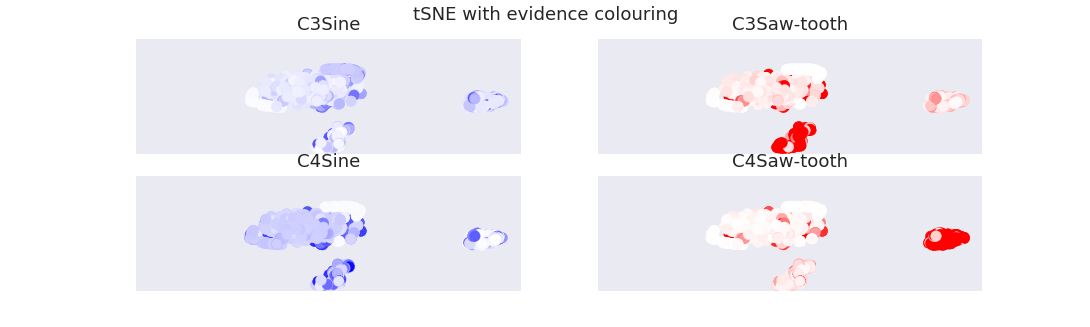

<IPython.core.display.Javascript object>


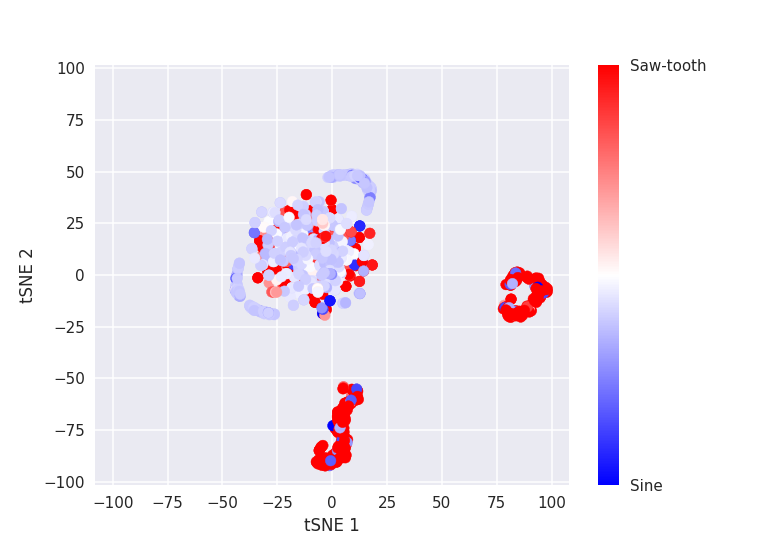

In [85]:
fig, ax = plt.subplots(ncols=2, nrows=n_channels, figsize=(5,12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.05, hspace=.1)
v = np.max(evidence)*0.5 #0.05#1e-8# 5e-6
pcxlim = 1.1*np.max(np.abs(red[:,0]))
pcylim = 1.1*np.max(np.abs(red[:,1]))
#print(evidence.shape)



for chan in range(n_channels):
    for cls in range(2):
        im = ax[chan, cls].scatter(red[:,0],red[:,1], c=evidence[:,chan,cls], vmin=-v, vmax=v, cmap='bwr')
        #ax[chan,cls].set_title(chn_names[chan] + grp_names[cls])
        if cls==1:
            ax[chan,cls].text(85,0, chn_names[chan], fontsize=15)
        if chan == 0:
            ax[chan,cls].set_title(grp_names[cls], fontsize=15)
        #if cls == 1:
        #    ax[chan,cls].
        if chan == n_channels-1:
            ax[chan,cls].set_xlabel('tSNE1', fontsize=15)
        else:
            ax[chan,cls].set_xticklabels([])
        
        if cls == 0:
            ax[chan,cls].set_ylabel('tSNE2', fontsize=15)
        else:
            ax[chan,cls].set_yticklabels([])
            
        ax[chan,cls].set_xlim([-pcxlim, pcxlim])
        ax[chan,cls].set_ylim([-pcylim, pcylim])
#cb = fig.colorbar(im,ax=ax[1,1])
#cb.set_ticks([-v,v])
#cb.set_ticklabels([grp_names[0], grp_names[1]])
plt.show()

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,5))
v = np.max(np.abs(total_evidence)) #0.05#1e-8# 5e-6
im = ax.scatter(red[:,0],red[:,1], c=total_evidence, vmin=-v, vmax=v, cmap='bwr')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-pcxlim, pcxlim])
ax.set_ylim([-pcylim, pcylim])
plt.show()

#fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
#ax[0].scatter(red[:,0],red[:,1], c=grp)
#ax[1].scatter(gm.means_[:,0],gm.means_[:,1],c=range(gm.means_.shape[0]))
#plt.show()

<IPython.core.display.Javascript object>


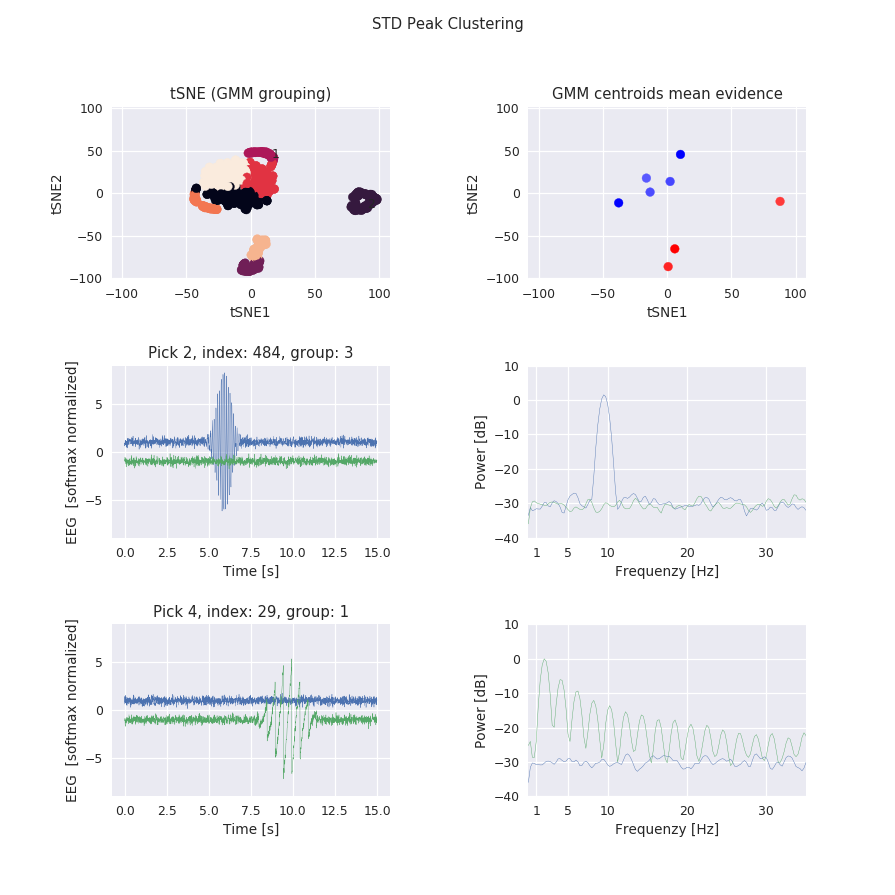

In [95]:
%matplotlib notebook

pcxlim = 1.1*np.max(np.abs(red[:,0]))
pcylim = 1.1*np.max(np.abs(red[:,1]))

t = np.arange(0,3*5, 1/fs)
f, axarr = plt.subplots(3, 2, sharex=False, squeeze=False, figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.5, hspace=.5)
axarr[0,0].scatter(red[:,0],red[:,1], c=grp, picker=True)
axarr[0,0].set_title('tSNE (GMM grouping)')
axarr[0,1].set_title('GMM centroids mean evidence')
for i in range(3):
    for j in range(2):
        axarr[i,j].spines['top'].set_visible(False)
        axarr[i,j].spines['right'].set_visible(False)
axarr[1,0].set_title('Pick 1')
axarr[2,0].set_title('Pick 2')

axarr[0,0].set_xlabel('tSNE1')
axarr[0,1].set_xlabel('tSNE1')
axarr[0,0].set_ylabel('tSNE2')
axarr[0,1].set_ylabel('tSNE2')
axarr[0,1].scatter(gm.means_[:,0],gm.means_[:,1],
                   c=grp_evidence,#c=range(gm.means_.shape[0]),
                   picker=True,
                   cmap='bwr')
for i in range(2):
    axarr[0,i].set_xlim([-pcxlim, pcxlim])
    axarr[0,i].set_ylim([-pcylim, pcylim])
pick_text = [None,None]

collector = []
sep = 1
yl = 9
lw = 0.33
def onpick(e):
    axes = e.canvas.figure.axes
    collector.append(axes)
    ind = e.ind
    if e.mouseevent.inaxes == axes[0]:
        if len(ind) != 1:
            ind = ind[0]
        ax = 2 if e.mouseevent.button == 1 else 4
        axes[ax].clear()
        axes[ax].plot(t,np.squeeze(peaks[ind,0,:])+sep, linewidth=lw)
        axes[ax].plot(t,np.squeeze(peaks[ind,1,:])-sep, linewidth=lw)
        axes[ax].set_ylim([-yl,yl])
        axes[ax].set_ylabel('EEG  [softmax normalized]')
        axes[ax].set_xlabel('Time [s]')
        axes[ax].set_title('Pick ' + str(ax) + ', index: ' + str(ind) + ', group: ' + str(grp[ind]))# + ', prob: ' + str(np.max(prop[ind])) )
        if pick_text[ax//2-1] != None: pick_text[ax//2-1].remove()
        pick_text[ax//2-1] = axes[0].text(red[ind,0],red[ind,1],str(ax//2))

        f,Pxx = welch(np.squeeze(peaks[ind,0,:]), fs = fs, nfft = 500)
        Pxx0 = 10*np.log10(Pxx)
        f,Pxx = welch(np.squeeze(peaks[ind,1,:]), fs = fs, nfft = 500)
        Pxx1 = 10*np.log10(Pxx)

        axes[ax+1].clear()
        axes[ax+1].plot(f,Pxx0, linewidth=lw)
        axes[ax+1].plot(f,Pxx1, linewidth=lw)
        #axes[ax+1].set_xticks([1, 5, 10, 20])
        #axes[ax+1].set_xticklabels(['1','5','10','20'])
        axes[ax+1].set_xticks([1, 5, 10, 20, 30, 40, 50, 60])
        axes[ax+1].set_xlabel('Frequenzy [Hz]')
        axes[ax+1].set_ylabel('Power [dB]')
        #axes[ax+1].set_xlim([0,30])
        axes[ax+1].set_xlim([0,35])
        axes[ax+1].set_ylim([-40,10])
    elif e.mouseevent.inaxes == axes[1]:
        size = np.ones(grp.shape)*8
        size[grp == ind] = 20 if e.mouseevent.button == 1 else 8
        axes[0].collections[0].set_sizes(size)

cid = f.canvas.mpl_connect('pick_event', onpick)
f.suptitle('STD Peak Clustering\n\n\n')
#plt.iplot()
plt.show()

In [ ]:
1+1


<IPython.core.display.Javascript object>


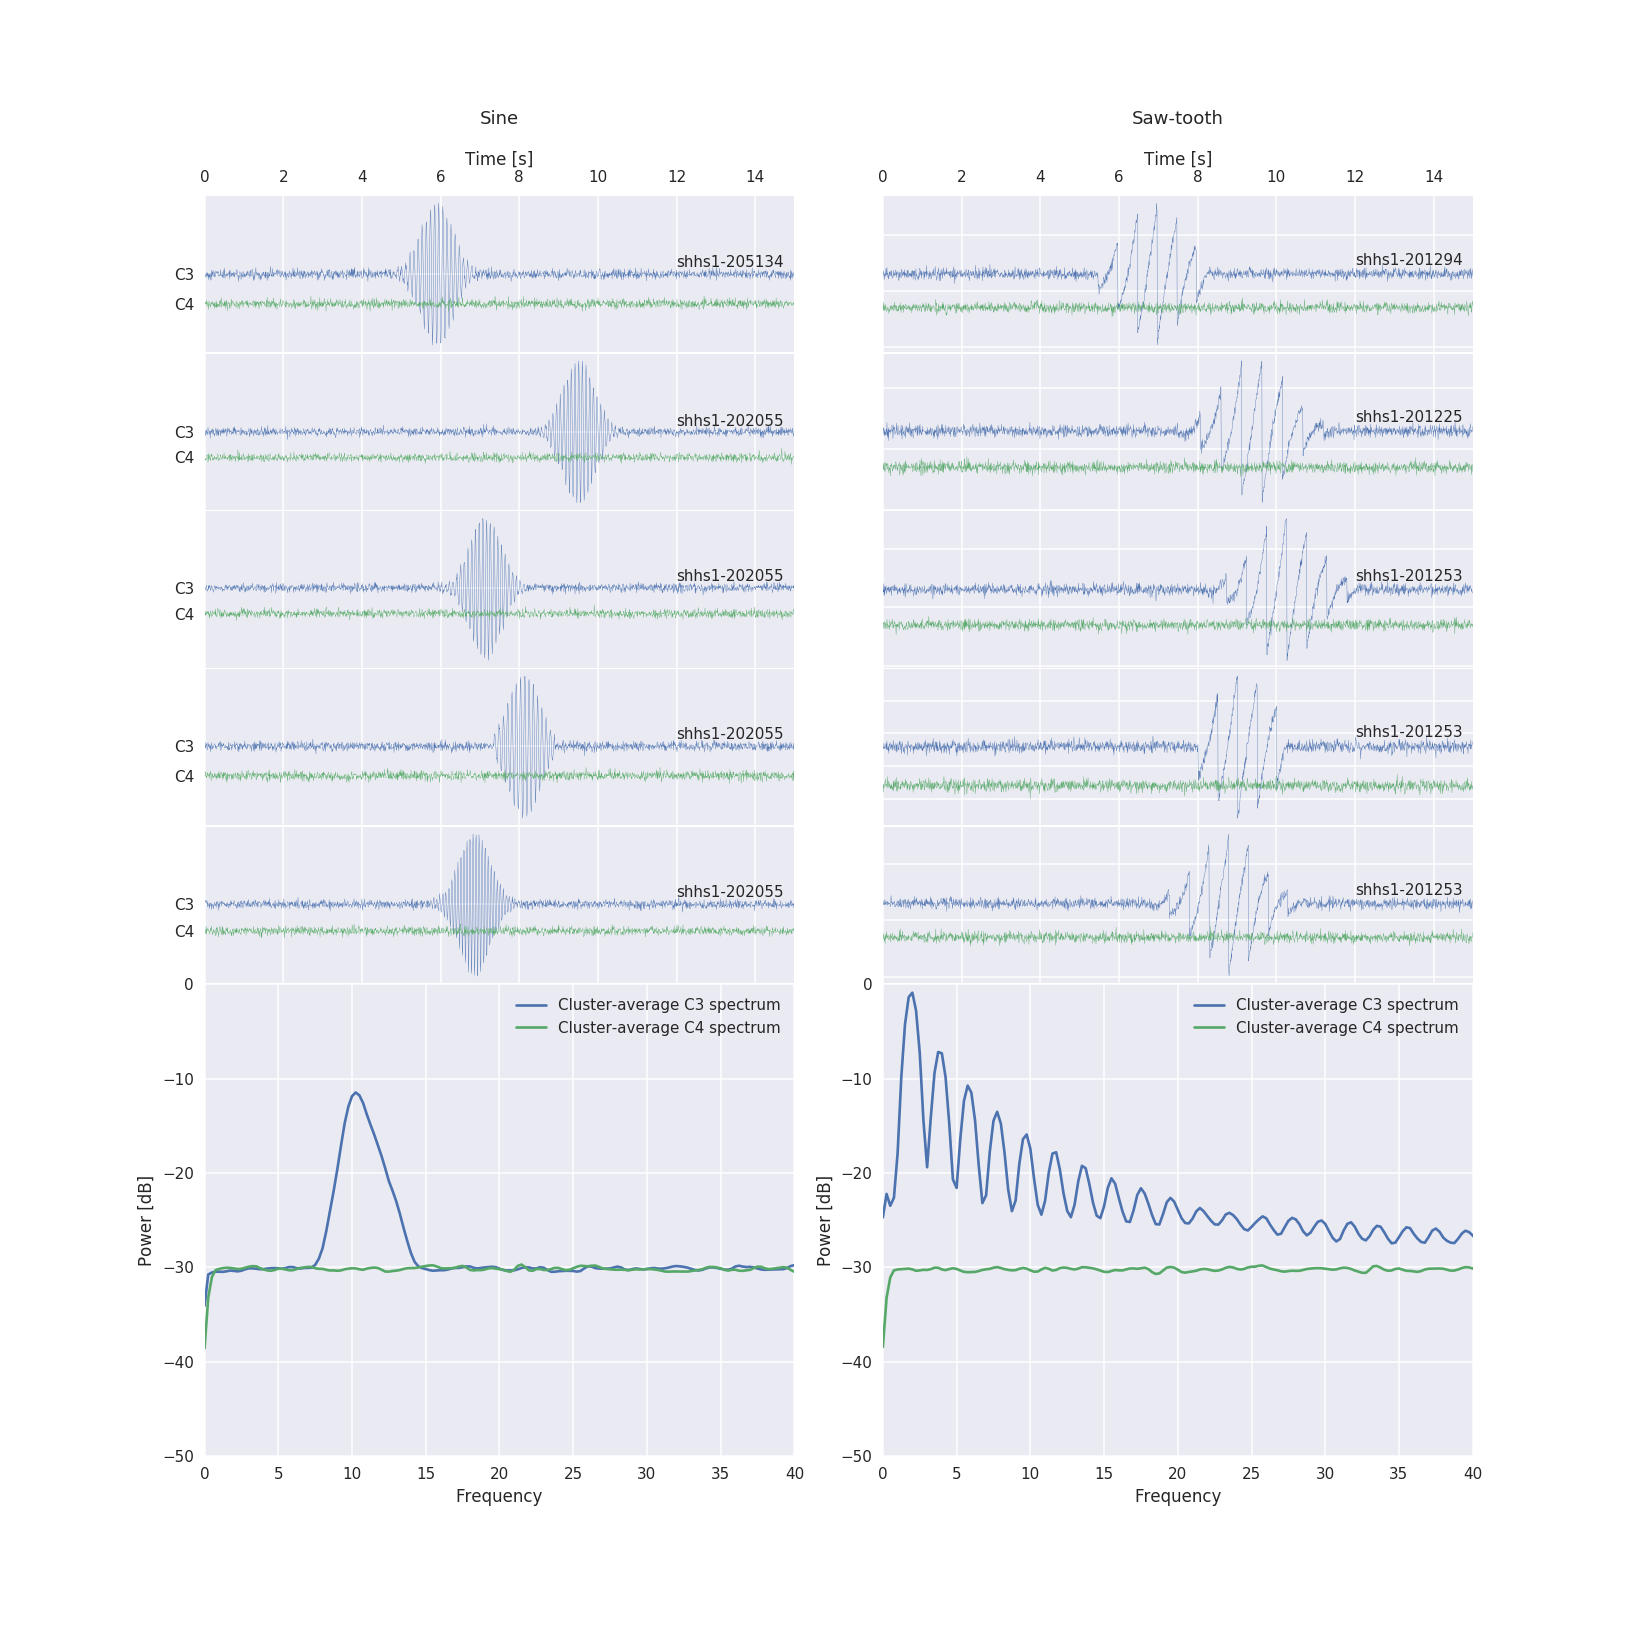

0
too few
1
too few


In [94]:
fig, ax = plt.subplots(nrows=n_cluster_examples+3, ncols=n_clusters, figsize=(15,15))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=.15, hspace=.01)
sep = 1.5
lw = .25
axes = []
for k in range(len(grp_indices)):
    cluster_peaks = peaks[grp == grp_indices[k],:,:]
    cluster_ids = ids[grp == grp_indices[k]]
    f,Pxx = welch(cluster_peaks, fs = fs, nfft = 500)
    Pxx = 10*np.log10(Pxx)
    meanPxx = np.mean(Pxx, axis=0)
    #print(cluster_peaks.shape)
    #print(Pxx.shape)
    #print(meanPxx.shape)
    n_cluster_unique = np.unique(cluster_ids)
    
    d = {}
    for index, value in enumerate(cluster_ids):
        if value not in d:
            d[value] = index
    indices = [v for key,v in d.items()]
    print(k)
    if len(indices) != n_cluster_examples:
        if len(indices) < n_cluster_examples:
            print('too few')
            randoms = np.random.permutation(np.arange(cluster_peaks.shape[0]))
            for j in range(n_cluster_examples-len(indices)):
                indices.append(randoms[j])
        else:
            print('too many')
            indices = indices[:n_cluster_examples]
    indices = [int(e) for e in indices]
    
    for n in range(n_cluster_examples):
        x = cluster_peaks[indices[n],:,:]
        ax[n,k].text(12,sep*1.5, cluster_ids[indices[n]])
        #print(x.shape)

        ax[n,k].plot(t,x[0,:]+sep, linewidth=lw)
        ax[n,k].plot(t,x[1,:]-sep, linewidth=lw)
        if n == 0: ax[n,k].set_title(cluster_names[k], y = 1.4)
        if n != 0:#n_cluster_examples-1: 
            ax[n,k].set_xticklabels([])
        else:
            ax[n,k].xaxis.tick_top()
            ax[n,k].set_xlabel('Time [s]')
            ax[n,k].xaxis.set_label_position('top') 
        if k != 0: 
            ax[n,k].set_yticklabels([])
        else:
            ax[n,k].set_yticks([-sep, sep])
            ax[n,k].set_yticklabels(['C4', 'C3'])
        ax[n,k].autoscale(enable=True, axis='x', tight=True)
    axes.append(plt.subplot2grid((n_cluster_examples+3, n_clusters), (n_cluster_examples, k), rowspan=3))
    c3, = axes[-1].plot(f, meanPxx[0,:], label='Cluster-average C3 spectrum')
    c4, = axes[-1].plot(f, meanPxx[1,:], label='Cluster-average C4 spectrum')
    
    axes[-1].legend(handles=[c3, c4])
    axes[-1].set_xlim([0,40])
    axes[-1].set_ylim([-50,0])
    axes[-1].set_xlabel('Frequency')
    axes[-1].set_ylabel('Power [dB]')
    #plt.subplot(n)
    #ax[n:n+3,k].plot([0,0], [0,0])

plt.show()


<IPython.core.display.Javascript object>


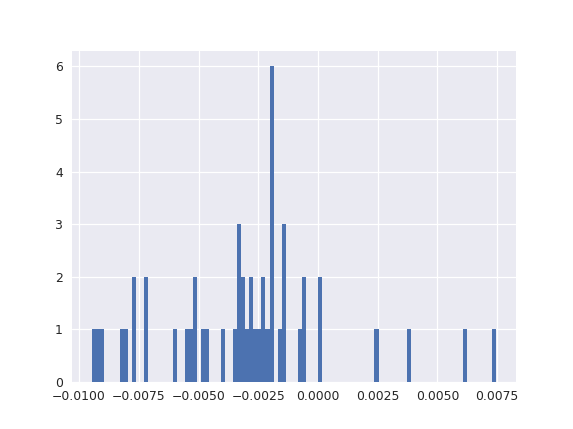

In [220]:
plt.hist(grp_evidence, bins = 100)
plt.show()